In [1]:
import numpy as np 
import pandas as pd 
import xarray as xr 
from tqdm import tqdm
import regionmask
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# settings
input_path            = '/Users/schoens/Documents/Projekte/Econ/'
# scenarios             = ['Ref1p5', 'Neg', 'SP', 'ssp119', 'GS', 'ssp534-over', 'ModAct', 'CurPol']
scenarios             = ['Ref', 'Neg']
scenarios_old         = ['Ref1p5', 'Neg']
n_scenarios           = len(scenarios) 
labelsize_large = 19
labelsize_medium = 17
labelsize_small  = 17

In [3]:
# gdp data
gdp_df                 = pd.read_csv(f'{input_path}Data/BHM/Full Data BHM Main Result.csv')

# temperature data
all_gmt_realisations_smooth = np.zeros((n_scenarios, 86, 100))

for i_scen in range(len(scenarios)): 
    scenario = scenarios[i_scen]
    fair_ids_100  = pd.read_csv(f'/Users/schoens/Documents/Projekte/Econ/Data/FaIR_v3/ids_reconstructed.csv', sep = ',', index_col = 0).dropna(how = 'all', axis = 1).rename(columns = {'Ref_1p5': 'Ref'})
    all_fair_runs = pd.read_csv(f'/Users/schoens/Documents/Projekte/Econ/Data/FaIR_v3/scen_{scenario}.csv', index_col = 0).iloc[:, fair_ids_100.loc[:, scenario].values].loc[slice(2015,2100),:]
    all_fair_runs.columns = np.arange(100)
    mesmer_ids = xr.load_dataset(f'/Users/schoens/Documents/Projekte/Econ/Data/MESMER/fldmean/{scenario}_fldmean.nc')['fair_esm_variability_realisation'].values
    fair_ids_mesmer = [int(f.split('_')[0]) for f in mesmer_ids]
    
    all_gmt_realisations_smooth[i_scen, :, :] = all_fair_runs.loc[:, fair_ids_mesmer]

gmt_tmp = np.moveaxis(all_gmt_realisations_smooth, [0,1,2], [0,2,1]).reshape(-1, 86)
del all_gmt_realisations_smooth

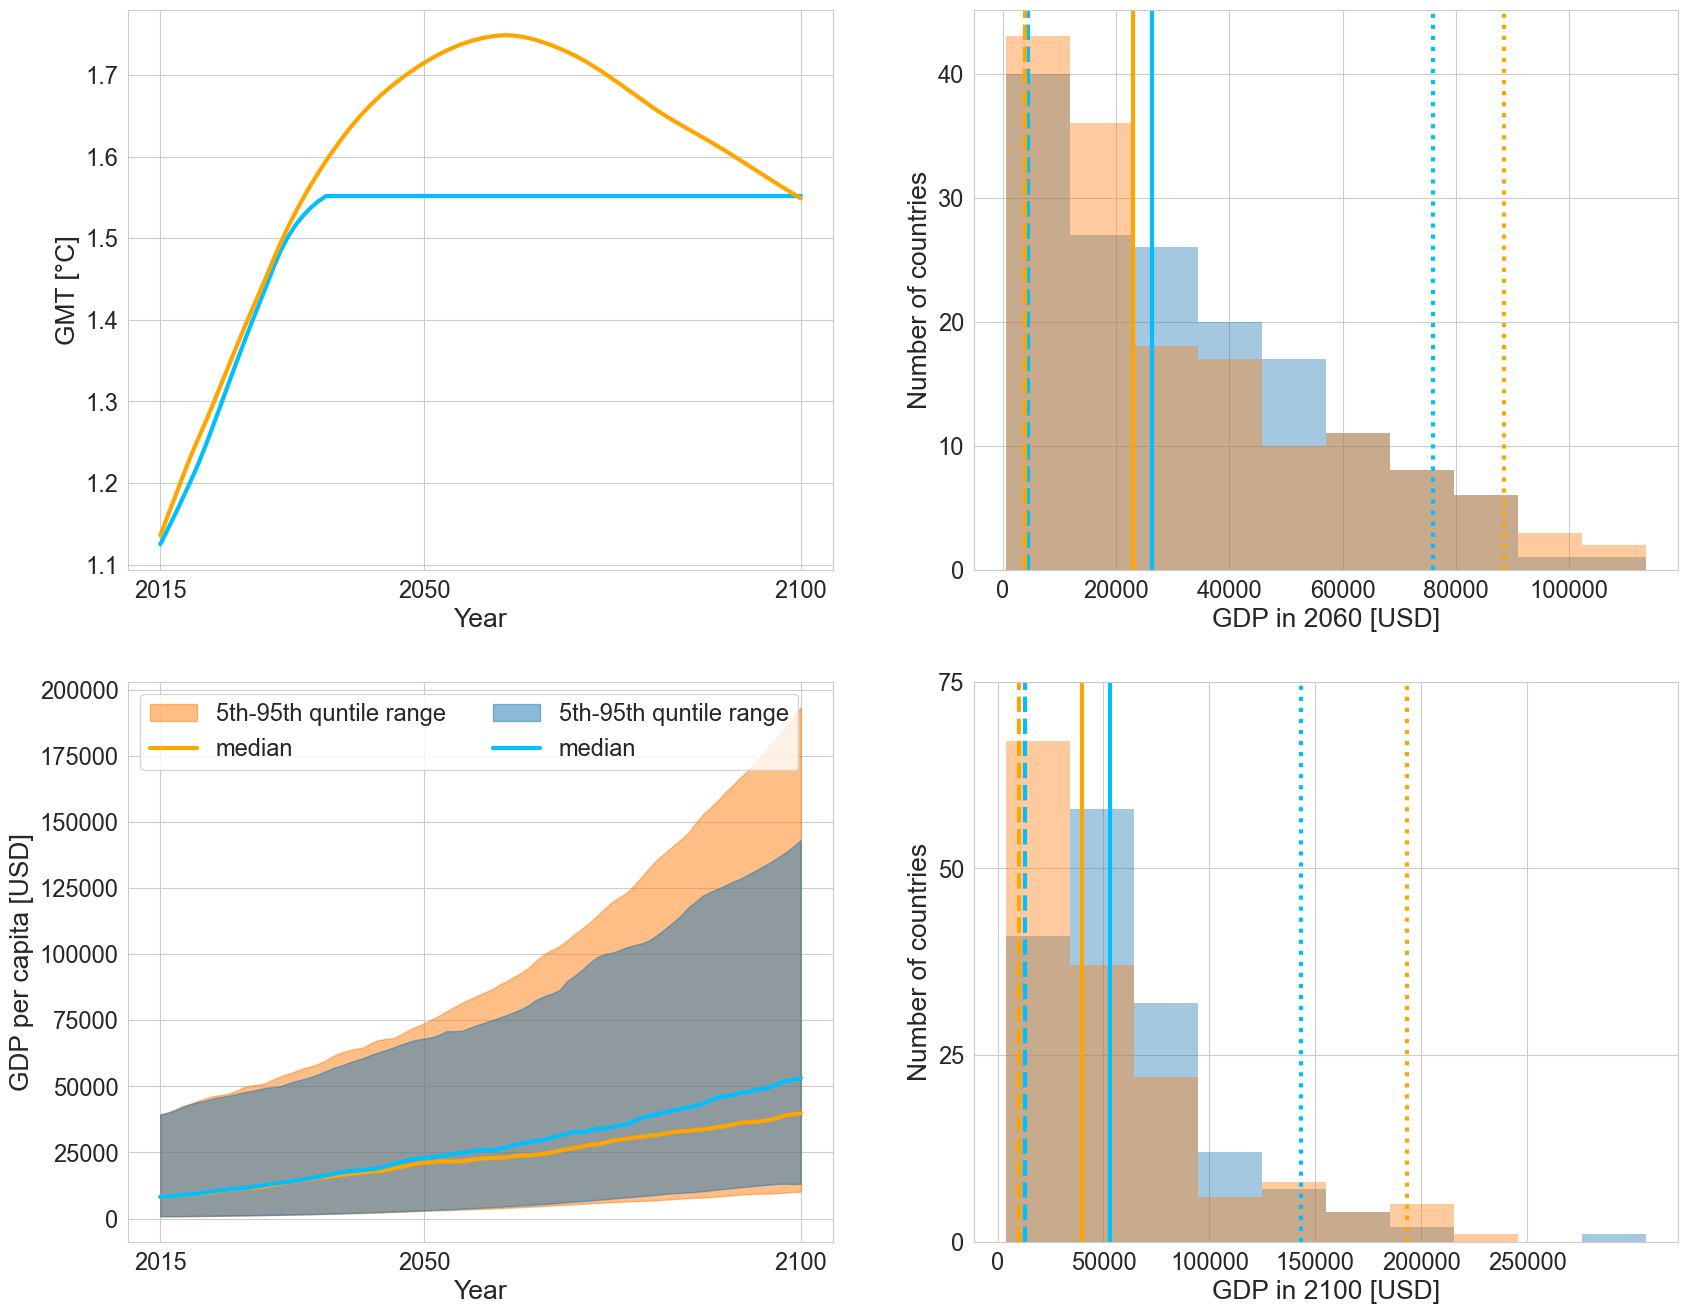

In [4]:
i, j = 76, 189

run1        = i%100
scenario1   = int((i-run1)/100)

run2        = j%100
scenario2   = int((j-run2)/100)

gdp_scen_1 = gdp_df[(gdp_df.scen == scenarios_old[scenario1]) & (gdp_df.run == run1+1)].loc[:, ["year", "SSP2_clim"]]
gdp_scen_2 = gdp_df[(gdp_df.scen == scenarios_old[scenario2]) & (gdp_df.run == run2+1)].loc[:, ["year", "SSP2_clim"]]

color_ref  = '#00BFFF'
color_neg  ='#FFA500'

def q1(x):
    return x.quantile(0.05)

def q3(x):
    return x.quantile(0.95)

f = {'SSP2_clim': ['median', q1, q3]}

with sns.axes_style("whitegrid"):
    fig, axes  = plt.subplots(ncols = 2, nrows = 2, figsize = (20,16))
    
    ax = axes[0,0]
    ax.plot(np.linspace(2015, 2100, 86), gmt_tmp[i, :], color = color_ref, lw = 3)
    ax.plot(np.linspace(2015, 2100, 86), gmt_tmp[j, :], color = color_neg, lw = 3)
    ax.set_ylabel("GMT [°C]", fontsize = labelsize_large)
    ax.tick_params(axis = 'both', labelsize = labelsize_small)
    ax.set_xlabel("Year", fontsize = labelsize_large)
    ax.set_xticks([2015,2050,2100])
    ax.set_xticklabels([2015,2050,2100], fontsize = labelsize_small)
    
    gdp_scen1_q_df = gdp_scen_1.groupby('year').agg(f)
    gdp_scen2_q_df = gdp_scen_2.groupby('year').agg(f)
    
    ax = axes[1,0]

    ax.fill_between(gdp_scen2_q_df.index, gdp_scen2_q_df.SSP2_clim.q1, gdp_scen2_q_df.SSP2_clim.q3, alpha = .5,
                     edgecolor = (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
                     facecolor = (1.0, 0.4980392156862745, 0.054901960784313725, 0.2),
                     label = "5th-95th quntile range")
    ax.plot(gdp_scen2_q_df.index, gdp_scen2_q_df.SSP2_clim["median"], color = color_neg, linewidth = 3, label = "median")
    ax.fill_between(gdp_scen1_q_df.index, gdp_scen1_q_df.SSP2_clim.q1, gdp_scen1_q_df.SSP2_clim.q3, alpha = .5, 
                     edgecolor = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
                     facecolor = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.2), 
                     label = "5th-95th quntile range")
    ax.plot(gdp_scen1_q_df.index, gdp_scen1_q_df.SSP2_clim["median"], color = color_ref, linewidth = 3,label = "median")
    ax.set_ylabel("GDP per capita [USD]", fontsize = labelsize_large)
    ax.set_xlabel("Year", fontsize = labelsize_large)
    ax.set_xticks([2015,2050,2100])
    ax.set_xticklabels([2015,2050,2100], fontsize = labelsize_small)
    ax.tick_params(axis = 'both', labelsize = labelsize_small)
    ax.legend(ncols = 2, loc = 'upper left', fontsize = labelsize_medium)
        
    ax = axes[1,1]

    _, bins, _  = ax.hist(gdp_scen_1[gdp_scen_1.year == 2100].SSP2_clim, alpha = .4, color = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.2), lw = 3, edgecolor = 'none')
    ax.hist(gdp_scen_2[gdp_scen_2.year == 2100].SSP2_clim, alpha = .4, bins = bins, color = (1.0, 0.4980392156862745, 0.054901960784313725, 0.2), lw = 3, edgecolor = 'none')
    ax.axvline(np.median(gdp_scen_1[gdp_scen_1.year == 2100].SSP2_clim), color = color_ref, linewidth = 3)
    ax.axvline(np.median(gdp_scen_2[gdp_scen_2.year == 2100].SSP2_clim), color = color_neg, linewidth = 3)
    ax.axvline(np.quantile(gdp_scen_1[gdp_scen_1.year == 2100].SSP2_clim, q = 0.05), color = color_ref, lw = 3, linestyle = "--")
    ax.axvline(np.quantile(gdp_scen_2[gdp_scen_2.year == 2100].SSP2_clim, q = 0.05), color = color_neg, lw = 3, linestyle = "--")
    ax.axvline(np.quantile(gdp_scen_1[gdp_scen_1.year == 2100].SSP2_clim, q = 0.95), color = color_ref, lw = 3, linestyle = "dotted")
    ax.axvline(np.quantile(gdp_scen_2[gdp_scen_2.year == 2100].SSP2_clim, q = 0.95), color = color_neg, lw = 3, linestyle = "dotted")
    ax.set_xlabel('GDP in 2100 [USD]', fontsize = labelsize_large)
    ax.set_ylabel('Number of countries', fontsize = labelsize_large)
    ax.set_xticks([0,50000,100000,150000,200000, 250000])
    ax.set_xticklabels([0,50000,100000,150000,200000, 250000], fontsize = labelsize_small)
    ax.set_yticks([0,25,50,75])
    ax.set_yticklabels([0,25,50,75], fontsize = labelsize_small)

    year = 2060

    ax = axes[0,1]
    _, bins, _  = ax.hist(gdp_scen_1[gdp_scen_1.year == year].SSP2_clim, alpha = .4, color = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.2), lw = 3, edgecolor = 'none')
    ax.hist(gdp_scen_2[gdp_scen_2.year == year].SSP2_clim, alpha = .4, bins = bins, color = (1.0, 0.4980392156862745, 0.054901960784313725, 0.2), lw = 3, edgecolor = 'none')
    ax.axvline(np.median(gdp_scen_1[gdp_scen_1.year == year].SSP2_clim), color = color_ref, lw = 3)
    ax.axvline(np.median(gdp_scen_2[gdp_scen_2.year == year].SSP2_clim), color = color_neg, lw = 3)
    ax.axvline(np.quantile(gdp_scen_1[gdp_scen_1.year == year].SSP2_clim, q = 0.05), color = color_ref, lw = 3, linestyle = "--")
    ax.axvline(np.quantile(gdp_scen_2[gdp_scen_2.year == year].SSP2_clim, q = 0.05), color = color_neg, lw = 3, linestyle = "--")
    ax.axvline(np.quantile(gdp_scen_1[gdp_scen_1.year == year].SSP2_clim, q = 0.95), color = color_ref, lw = 3, linestyle = "dotted")
    ax.axvline(np.quantile(gdp_scen_2[gdp_scen_2.year == year].SSP2_clim, q = 0.95), color = color_neg, lw = 3, linestyle = "dotted")
    ax.set_xlabel('GDP in 2060 [USD]', fontsize = labelsize_large)
    ax.set_ylabel('Number of countries', fontsize = labelsize_large)
    ax.set_xticks([0,20000,40000,60000,80000, 100000])
    ax.set_xticklabels([0,20000,40000,60000,80000, 100000], fontsize = labelsize_small)
    ax.set_yticks([0,10,20,30,40])
    ax.set_yticklabels([0,10,20,30,40], fontsize = labelsize_small)
    
    plt.show()

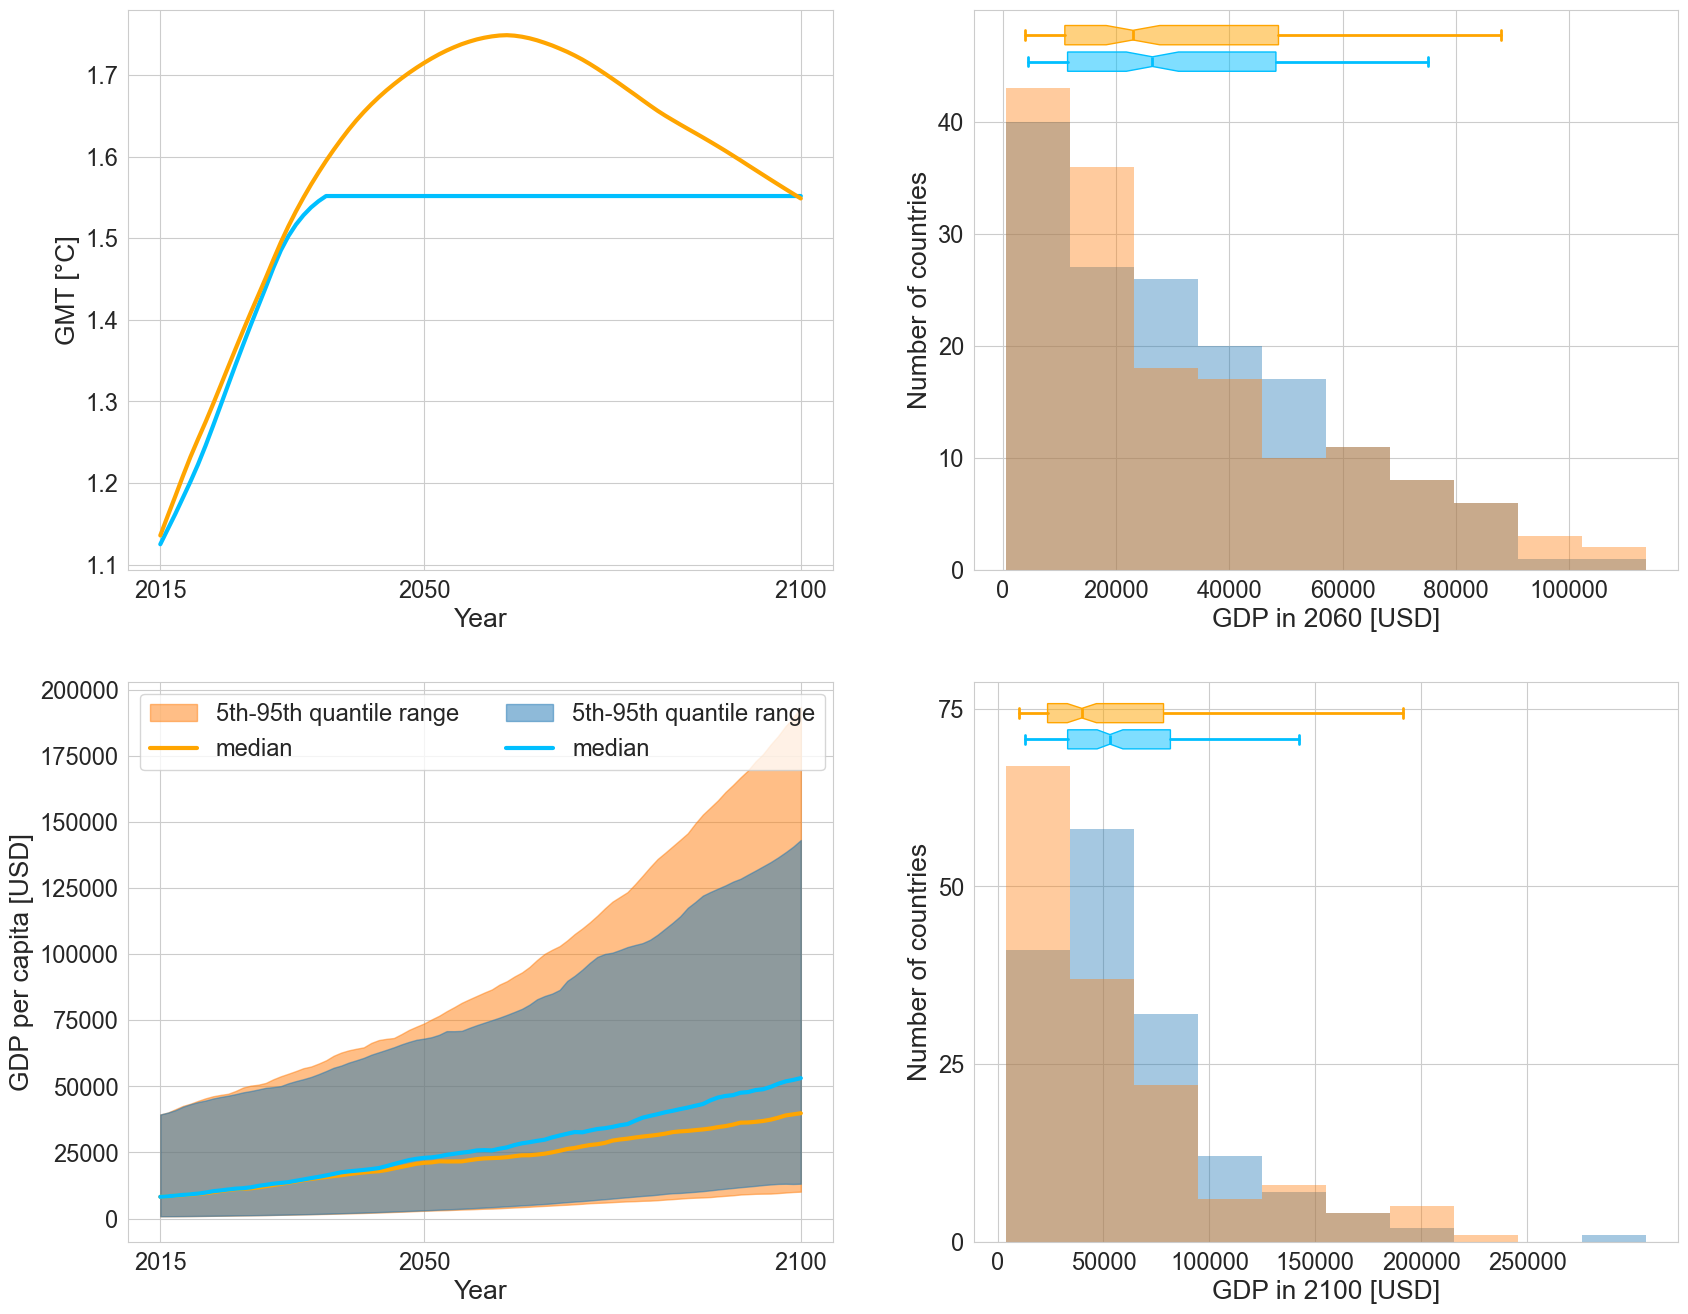

In [32]:
i, j = 76, 189

run1        = i % 100
scenario1   = int((i - run1) / 100)

run2        = j % 100
scenario2   = int((j - run2) / 100)

gdp_scen_1 = gdp_df[(gdp_df.scen == scenarios_old[scenario1]) & (gdp_df.run == run1 + 1)].loc[:, ["year", "SSP2_clim"]]
gdp_scen_2 = gdp_df[(gdp_df.scen == scenarios_old[scenario2]) & (gdp_df.run == run2 + 1)].loc[:, ["year", "SSP2_clim"]]

color_ref  = '#00BFFF'
color_neg  = '#FFA500'

# color_ref = (0.122, 0.467, 0.706, 1)
# color_neg = (1.0, 0.498, 0.0549, 1)

def q1(x):
    return x.quantile(0.05)

def q3(x):
    return x.quantile(0.95)

f = {'SSP2_clim': ['median', q1, q3]}

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 16))
    
    ax = axes[0, 0]
    ax.plot(np.linspace(2015, 2100, 86), gmt_tmp[i, :], color=color_ref, lw=3)
    ax.plot(np.linspace(2015, 2100, 86), gmt_tmp[j, :], color=color_neg, lw=3)
    ax.set_ylabel("GMT [°C]", fontsize=labelsize_large)
    ax.tick_params(axis='both', labelsize=labelsize_small)
    ax.set_xlabel("Year", fontsize=labelsize_large)
    ax.set_xticks([2015, 2050, 2100])
    ax.set_xticklabels([2015, 2050, 2100], fontsize=labelsize_small)
    
    gdp_scen1_q_df = gdp_scen_1.groupby('year').agg(f)
    gdp_scen2_q_df = gdp_scen_2.groupby('year').agg(f)
    
    ax = axes[1, 0]
    ax.fill_between(gdp_scen2_q_df.index, gdp_scen2_q_df.SSP2_clim.q1, gdp_scen2_q_df.SSP2_clim.q3, alpha=0.5,
                    edgecolor=(1.0, 0.498, 0.0549, 1.0), facecolor=(1.0, 0.498, 0.0549, 0.2), label="5th-95th quantile range")
    ax.plot(gdp_scen2_q_df.index, gdp_scen2_q_df.SSP2_clim["median"], color=color_neg, linewidth=3, label="median")
    ax.fill_between(gdp_scen1_q_df.index, gdp_scen1_q_df.SSP2_clim.q1, gdp_scen1_q_df.SSP2_clim.q3, alpha=0.5,
                    edgecolor=(0.122, 0.467, 0.706, 1.0), facecolor=(0.122, 0.467, 0.706, 0.2), label="5th-95th quantile range")
    ax.plot(gdp_scen1_q_df.index, gdp_scen1_q_df.SSP2_clim["median"], color=color_ref, linewidth=3, label="median")
    ax.set_ylabel("GDP per capita [USD]", fontsize=labelsize_large)
    ax.set_xlabel("Year", fontsize=labelsize_large)
    ax.set_xticks([2015, 2050, 2100])
    ax.set_xticklabels([2015, 2050, 2100], fontsize=labelsize_small)
    ax.tick_params(axis='both', labelsize=labelsize_small)
    ax.legend(ncols=2, loc='upper left', fontsize=labelsize_medium)
        
    year_2100 = 2100
    year_2060 = 2060
    
    def plot_boxplot(ax, data1, data2, year, color1, color2):
        _, bins, _ = ax.hist(data1[data1.year == year].SSP2_clim, alpha=0.4,
                             color=(0.122, 0.467, 0.706, 0.2), lw=3, edgecolor='none')
        ax.hist(data2[data2.year == year].SSP2_clim, alpha=0.4, bins=bins,
                color=(1.0, 0.498, 0.0549, 0.2), lw=3, edgecolor='none')
        
        box_data1 = data1[data1.year == year].SSP2_clim
        box_data2 = data2[data2.year == year].SSP2_clim
        
        max_count = max(np.histogram(box_data1, bins=bins)[0].max(), np.histogram(box_data2, bins=bins)[0].max())
        plus      = max_count*0.05
        box_pos = max_count + 1.1*plus  # Slightly above the highest point of the distribution
        
        ax.boxplot(box_data1, positions=[box_pos], widths=0.8*plus, vert=False,notch=True,
                   patch_artist=True, whis=[5, 95], boxprops=dict(facecolor=(color1, 0.5), color=color1),
                   medianprops=dict(color=color1, linewidth = 2), whiskerprops=dict(color=color1, linewidth = 2),
                   capprops=dict(color=color1, linewidth=2), showfliers = False, flierprops=dict(markerfacecolor=color1, markeredgecolor=color1))
        
        ax.boxplot(box_data2, positions=[box_pos + 1.1*plus], widths=0.8*plus, vert=False,notch=True,
                   patch_artist=True, whis=[5, 95], boxprops=dict(facecolor = (color2, 0.5), color=color2),
                   medianprops=dict(color=color2, linewidth = 2), whiskerprops=dict(color=color2, linewidth = 2),
                   capprops=dict(color=color2, linewidth = 2), showfliers = False, flierprops=dict(markerfacecolor=color2, markeredgecolor=color2))
        
        return ax

    ax = axes[1, 1]
    ax = plot_boxplot(ax, gdp_scen_1, gdp_scen_2, year_2100, color_ref, color_neg)
    ax.set_xlabel('GDP in 2100 [USD]', fontsize=labelsize_large)
    ax.set_ylabel('Number of countries', fontsize=labelsize_large)
    ax.set_xticks([0, 50000, 100000, 150000, 200000, 250000])
    ax.set_xticklabels([0, 50000, 100000, 150000, 200000, 250000], fontsize=labelsize_small)
    ax.set_yticks([0, 25, 50, 75])
    ax.set_yticklabels([0, 25, 50, 75], fontsize=labelsize_small)

    ax = axes[0, 1]
    ax = plot_boxplot(ax, gdp_scen_1, gdp_scen_2, year_2060, color_ref, color_neg)
    ax.set_xlabel('GDP in 2060 [USD]', fontsize=labelsize_large)
    ax.set_ylabel('Number of countries', fontsize=labelsize_large)
    ax.set_xticks([0, 20000, 40000, 60000, 80000, 100000])
    ax.set_xticklabels([0, 20000, 40000, 60000, 80000, 100000], fontsize=labelsize_small)
    ax.set_yticks([0, 10, 20, 30, 40])
    ax.set_ylim(0,50)
    ax.set_yticklabels([0, 10, 20, 30, 40], fontsize=labelsize_small)
    
    plt.show()

In [35]:
cset.scenarios

['ssp119',
 'SP',
 'Neg',
 'LD',
 'Ren',
 'Ref',
 'GS',
 'ssp534-over',
 'ModAct',
 'CurPol']

In [37]:
# showing the quantitative, systematic shift:
import sys
sys.path.append('/Users/schoens/Documents/Projekte/Econ/Code/v3/')

import config.settings as cset

scenarios             = cset.scenarios
n_scenarios = len(scenarios)
# temperature data
all_gmt_realisations_smooth = np.zeros((n_scenarios, 86, 100))

for i_scen in range(len(scenarios)): 
    scenario = scenarios[i_scen]
    fair_ids_100  = pd.read_csv(f'/Users/schoens/Documents/Projekte/Econ/Data/FaIR_v3/ids_reconstructed.csv', sep = ',', index_col = 0).dropna(how = 'all', axis = 1).rename(columns = {'Ref_1p5': 'Ref'})
    all_fair_runs = pd.read_csv(f'/Users/schoens/Documents/Projekte/Econ/Data/FaIR_v3/scen_{scenario}.csv', index_col = 0).iloc[:, fair_ids_100.loc[:, scenario].values].loc[slice(2015,2100),:]
    all_fair_runs.columns = np.arange(100)
    mesmer_ids = xr.load_dataset(f'/Users/schoens/Documents/Projekte/Econ/Data/MESMER/fldmean/{scenario}_fldmean.nc')['fair_esm_variability_realisation'].values
    fair_ids_mesmer = [int(f.split('_')[0]) for f in mesmer_ids]
    
    all_gmt_realisations_smooth[i_scen, :, :] = all_fair_runs.loc[:, fair_ids_mesmer]

gmt_tmp = np.moveaxis(all_gmt_realisations_smooth, [0,1,2], [0,2,1]).reshape(-1, 86)
del all_gmt_realisations_smooth

In [8]:
all_gmt_realisations = np.zeros((n_scenarios, 86, 100))

for i_scen in range(len(scenarios)): 
    scenario = scenarios[i_scen]        
    all_gmt_realisations[i_scen, :, :] = xr.load_dataset(f'/Users/schoens/Documents/Projekte/Econ/Data/MESMER/fldmean/{scenario}_fldmean.nc')['tas'].values[:, -86:].T

gmt_tmp = np.moveaxis(all_gmt_realisations, [0,1,2], [0,2,1]).reshape(-1, 86)

In [18]:
all_gmt_realisations_smooth = np.zeros((n_scenarios, 86, 100))

for i_scen in range(len(scenarios)): 
    scenario = scenarios[i_scen]
    fair_ids_100  = pd.read_csv(f'/Users/schoens/Documents/Projekte/Econ/Data/FaIR_v3/ids_reconstructed.csv', sep = ',', index_col = 0).dropna(how = 'all', axis = 1).rename(columns = {'Ref_1p5': 'Ref'})
    all_fair_runs = pd.read_csv(f'/Users/schoens/Documents/Projekte/Econ/Data/FaIR_v3/scen_{scenario}.csv', index_col = 0).iloc[:, fair_ids_100.loc[:, scenario].values].loc[slice(2015,2100),:]
    all_fair_runs.columns = np.arange(100)
    mesmer_ids = xr.load_dataset(f'/Users/schoens/Documents/Projekte/Econ/Data/MESMER/fldmean/{scenario}_fldmean.nc')['fair_esm_variability_realisation'].values
    fair_ids_mesmer = [int(f.split('_')[0]) for f in mesmer_ids]
    
    all_gmt_realisations_smooth[i_scen, :, :] = all_fair_runs.loc[:, fair_ids_mesmer]

gmt_tmp_smooth = np.moveaxis(all_gmt_realisations_smooth, [0,1,2], [0,2,1]).reshape(-1, 86)

In [21]:
idx_lists = []
for i in range(200): 
    idx_similar  = [(i,j) for j in range(200) if (not i == j) & (np.abs(gmt_tmp[j,0]-gmt_tmp[i,0]) <= 0.05) & (np.abs(gmt_tmp[j,-1]-gmt_tmp[i,-1]) <= 0.05)] 
    idx_lists += idx_similar
    # idx_lists.append(idx_similar)     
idx_lists  = list(set(tuple(sorted(l)) for l in idx_lists))
sel_tuples = [(i,j) for i,j in idx_lists if not np.all(gmt_tmp[i,:]-gmt_tmp[j,:] == 0)]

In [87]:
idx_lists = []
for i in range(200): 
    idx_similar  = [(i,j) for j in range(200) if (not i == j) & (np.abs(gmt_tmp_smooth[j,0]-gmt_tmp_smooth[i,0]) <= 0.025) & (np.abs(gmt_tmp_smooth[j,-1]-gmt_tmp_smooth[i,-1]) <= 0.025)] 
    idx_lists += idx_similar
    # idx_lists.append(idx_similar)     
idx_lists  = list(set(tuple(sorted(l)) for l in idx_lists))
sel_tuples = [(i,j) for i,j in idx_lists if not np.all(gmt_tmp_smooth[i,:]-gmt_tmp_smooth[j,:] == 0)]
sel_tuples = [(i,j) for i,j in sel_tuples if not int(i/100) == int(j/100)]

18 136


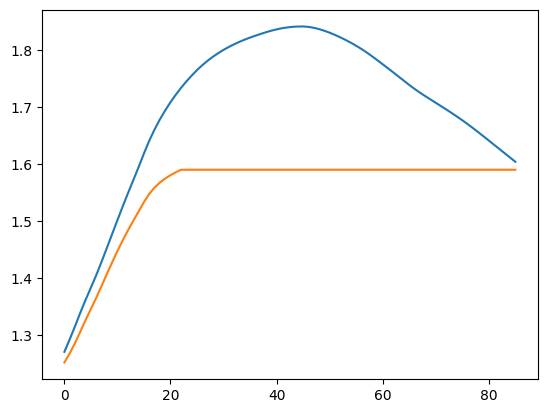

61 171


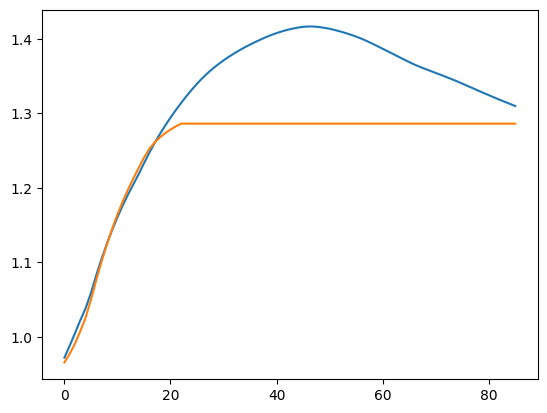

50 180


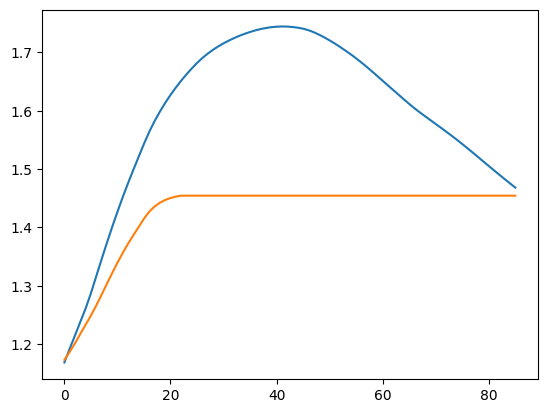

93 132


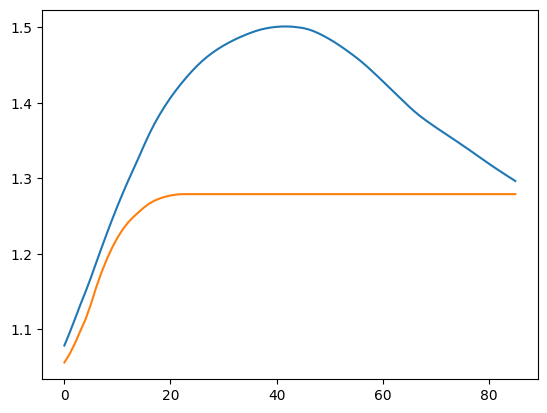

57 112


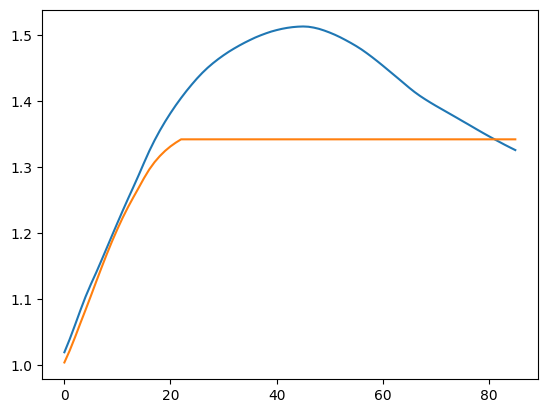

10 189


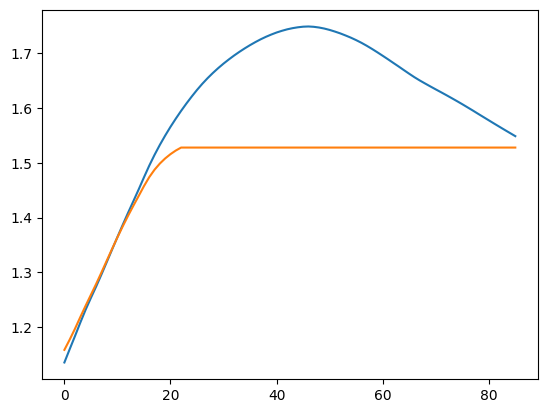

76 189


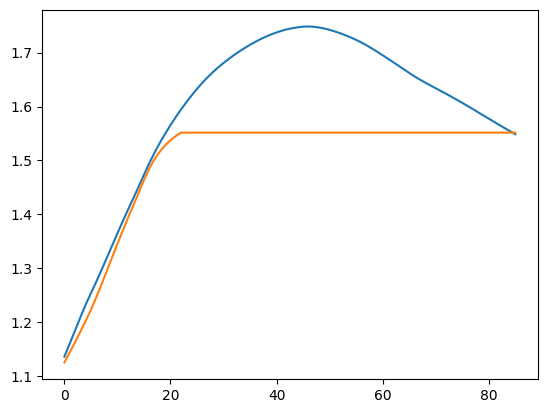

51 135


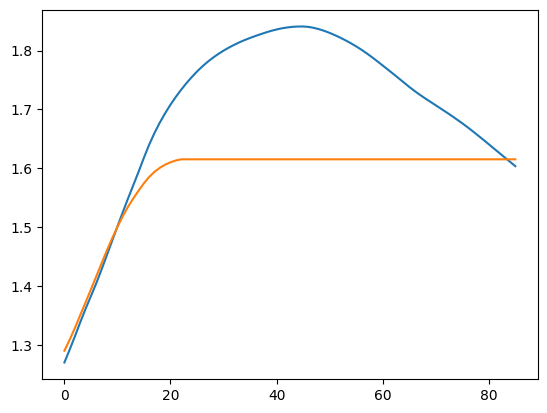

90 188


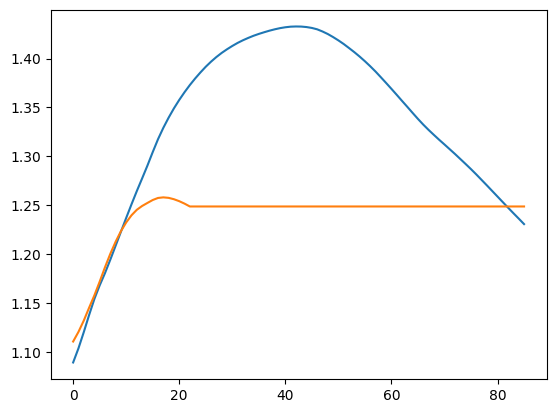

56 110


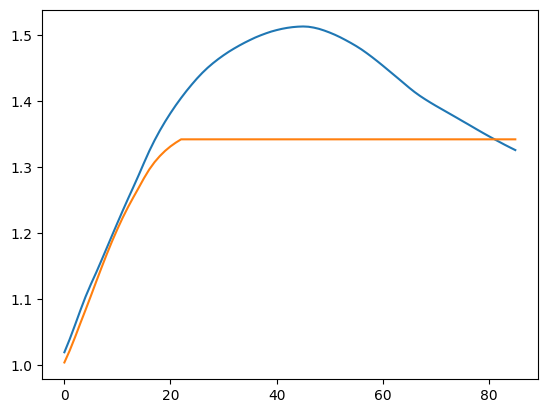

26 124


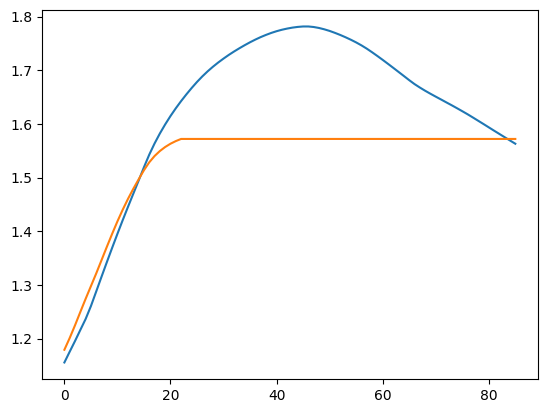

21 174


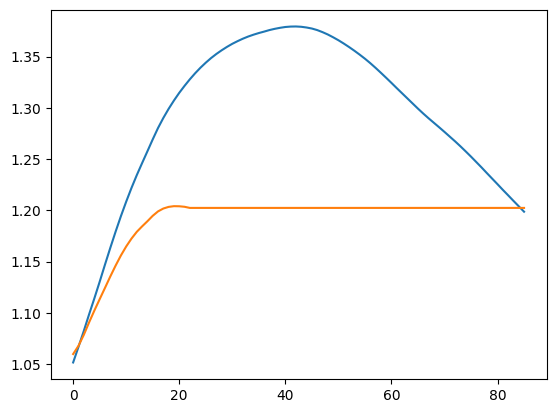

50 155


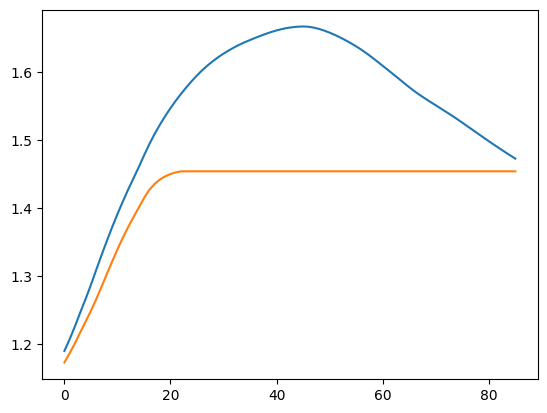

1 143


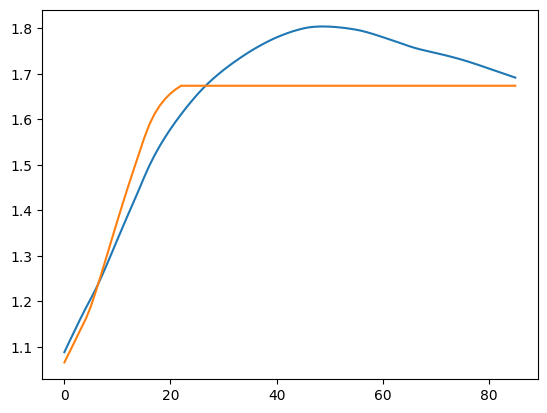

69 186


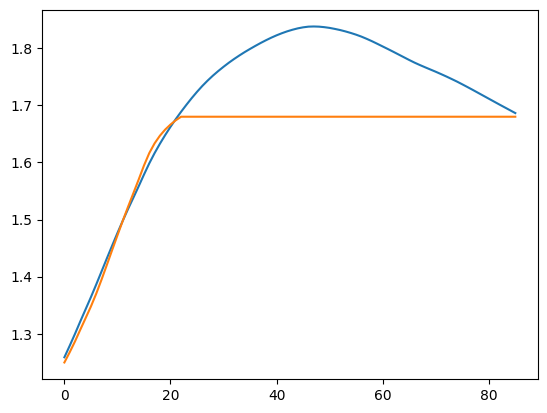

50 182


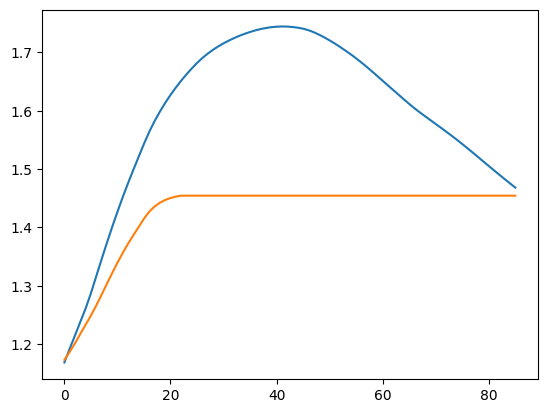

3 143


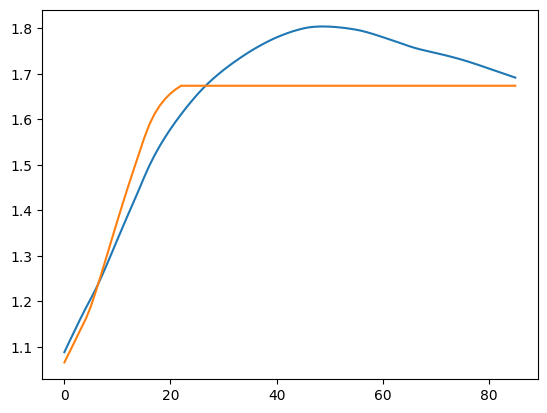

33 168


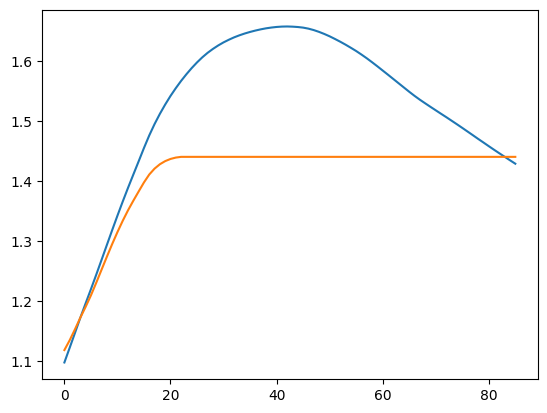

50 184


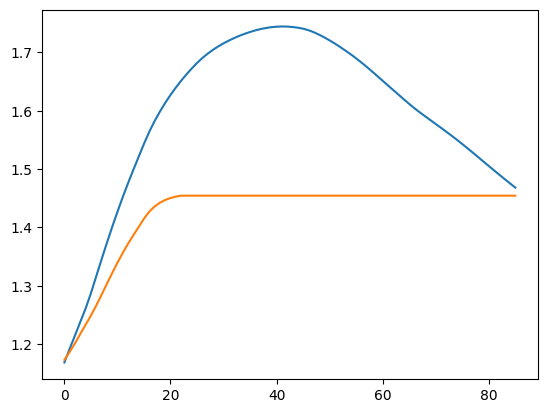

56 151


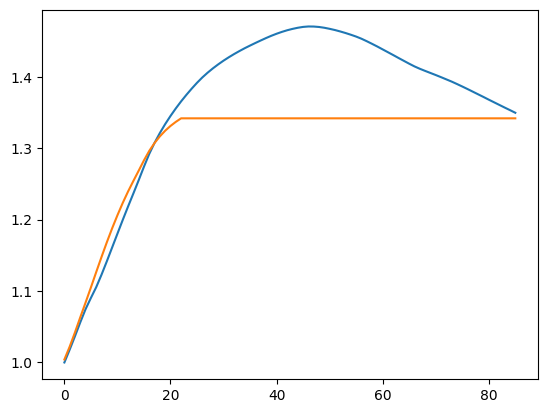

6 189


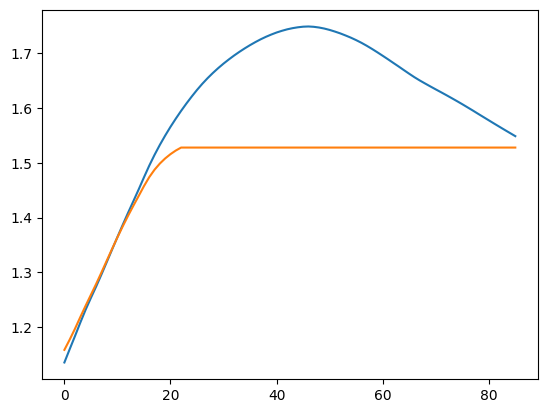

93 120


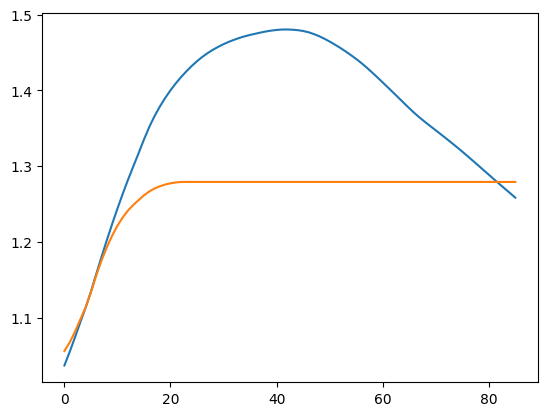

92 131


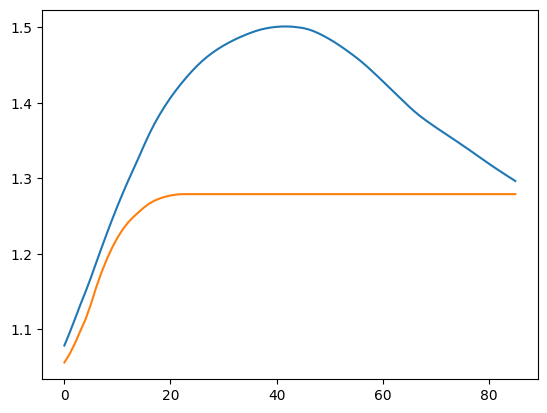

57 109


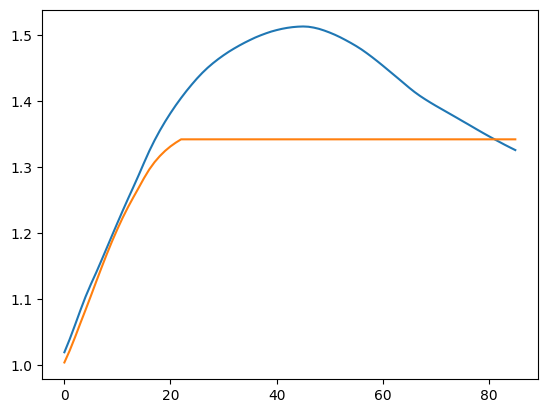

8 189


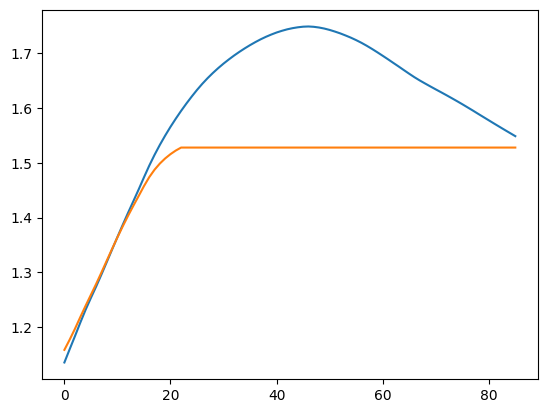

19 134


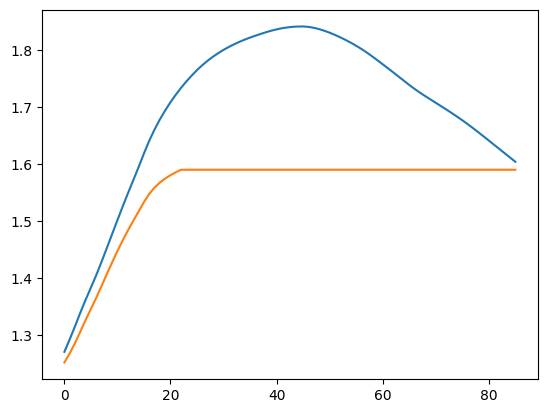

88 188


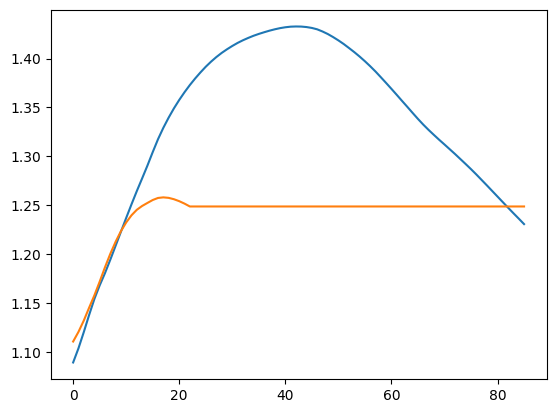

29 166


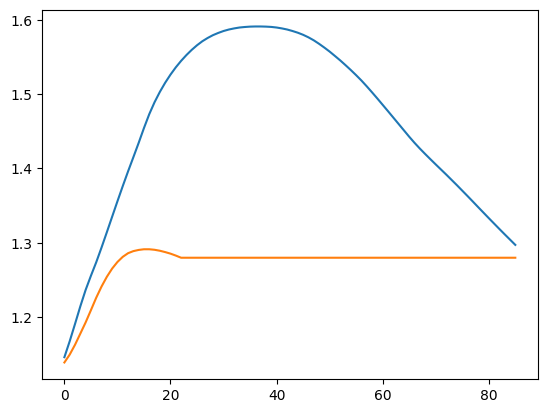

11 139


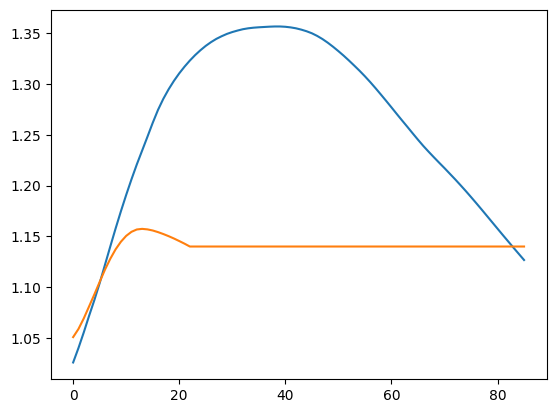

81 121


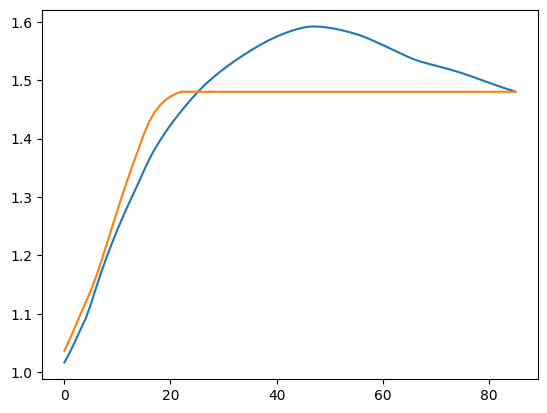

55 120


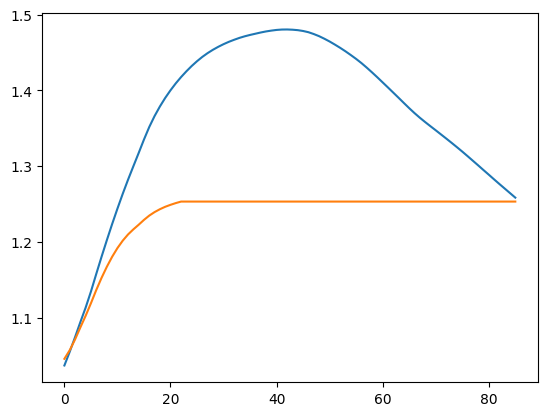

18 135


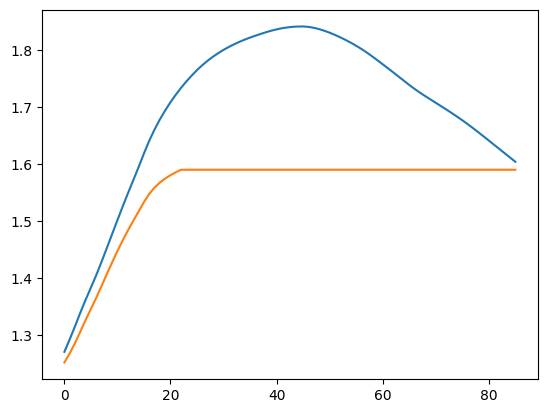

61 170


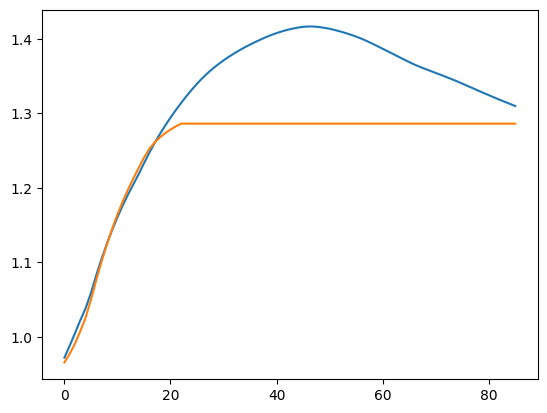

50 179


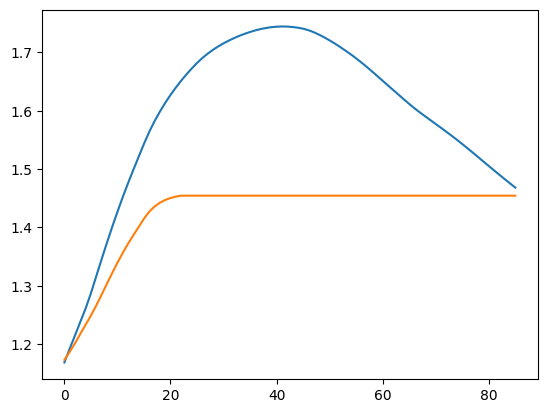

83 121


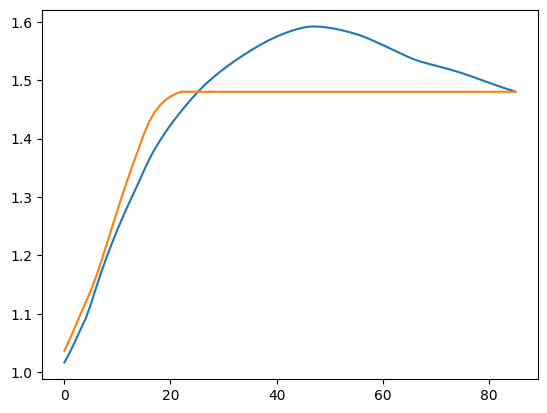

16 165


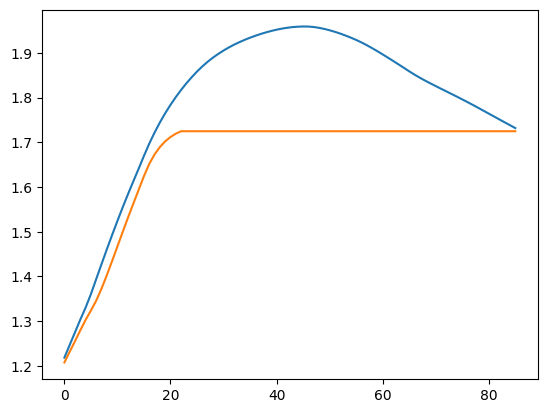

93 131


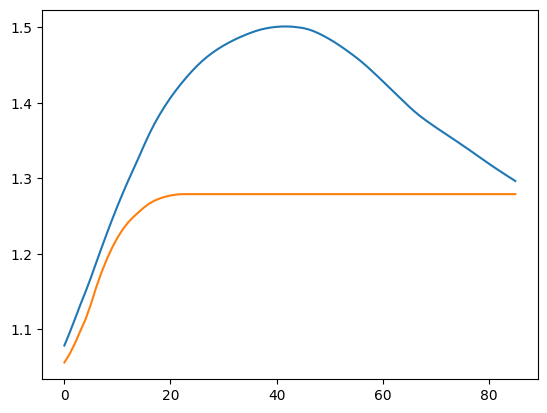

57 111


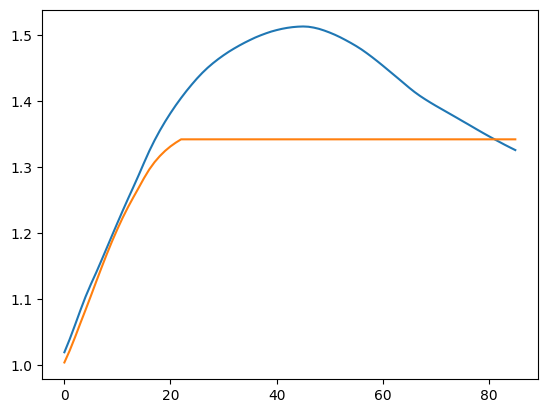

49 171


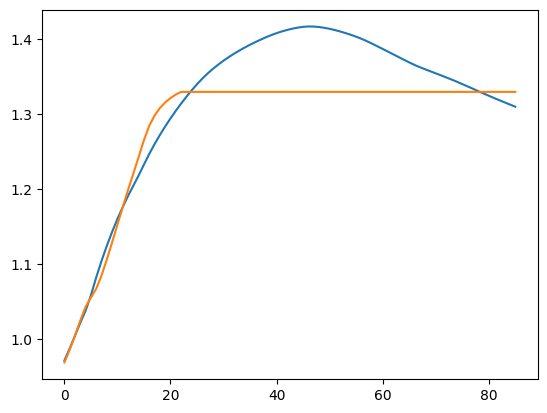

51 134


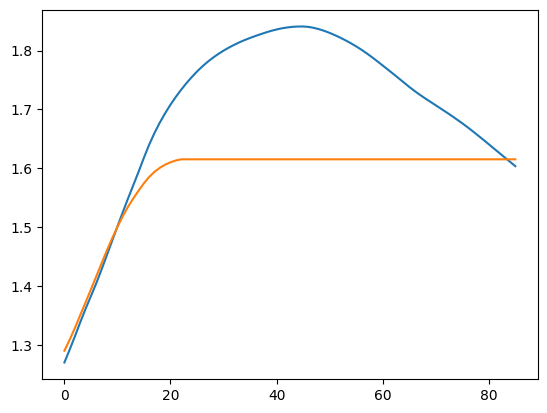

32 194


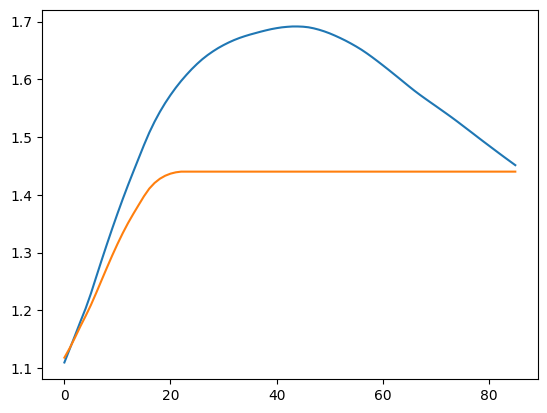

26 123


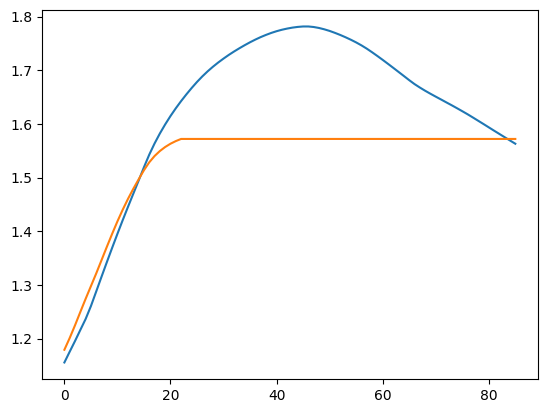

33 193


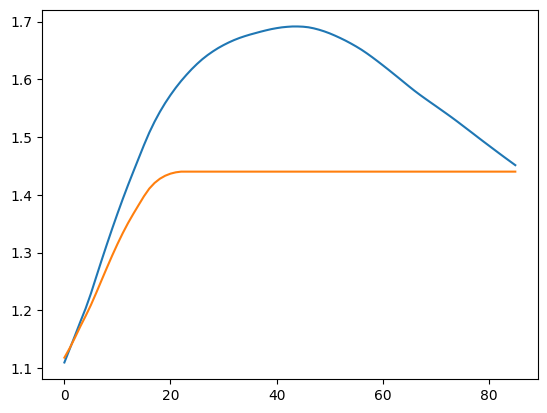

21 173


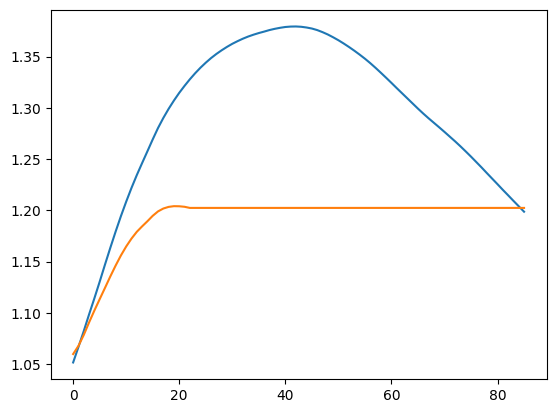

58 103


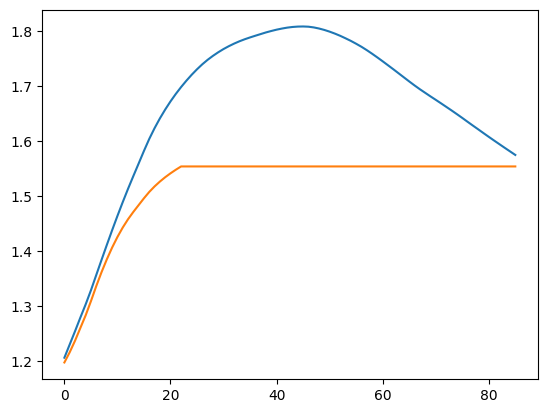

66 196


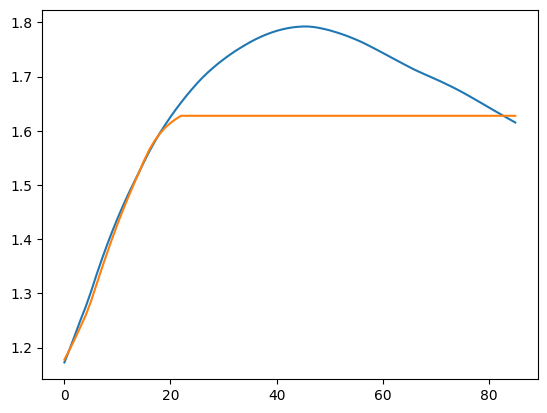

56 112


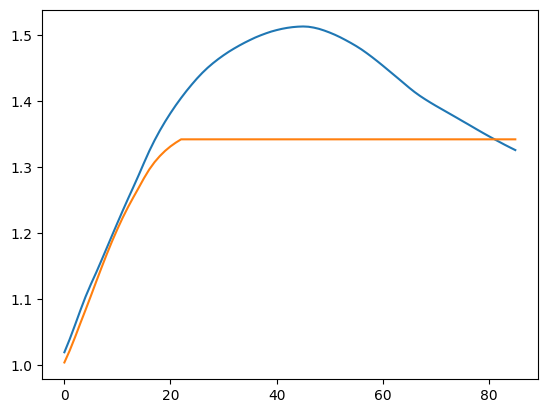

89 188


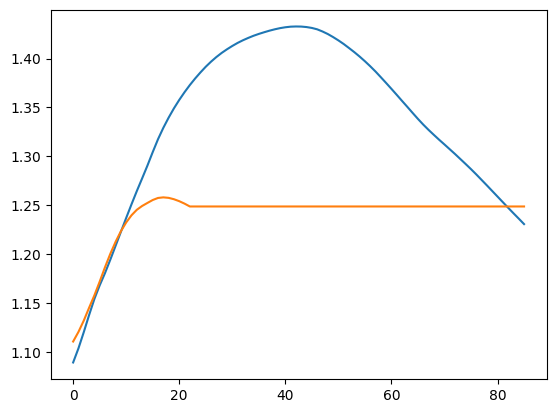

30 166


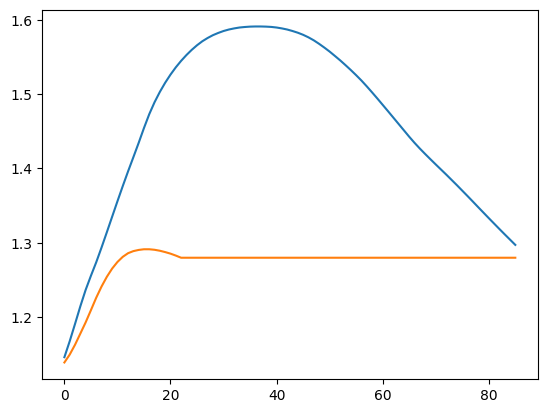

32 169


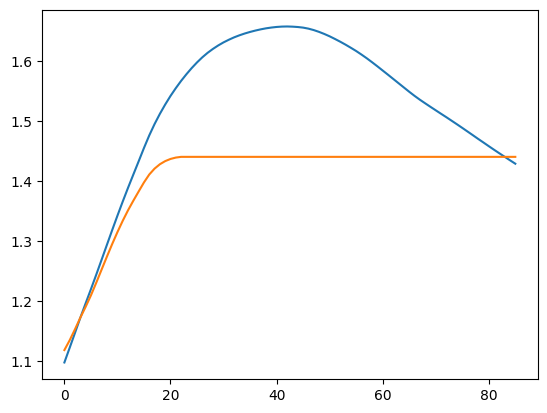

In [88]:
# options: [(6, 148), (75, 193), (97, 195), (39,169), (39, 195), (76, 147), (5,123), (0,102), (92, 169), (77, 102), (20,116)] 
for i, j in sel_tuples[:50]: 
    print(i,j)
    plt.figure()
    plt.plot(gmt_tmp_smooth[j, :])
    plt.plot(gmt_tmp_smooth[i, :])
    plt.show()

In [25]:
gdp_df                 = pd.read_csv(f'{input_path}Data/BHM/Full Data BHM Main Result.csv')

97 195


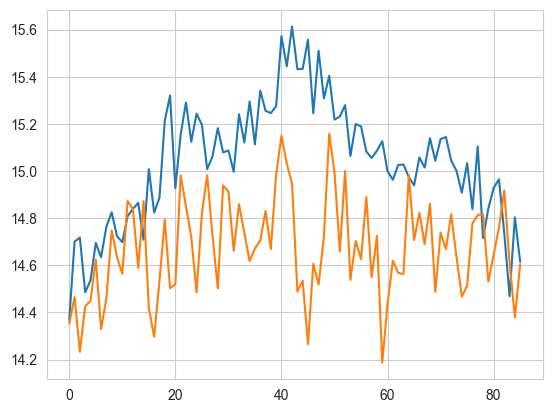

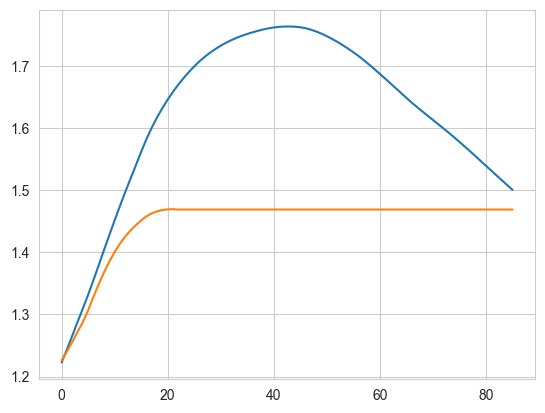

In [36]:
with sns.axes_style("whitegrid"):
    i,j = 97, 195
    print(i,j)
    plt.figure()
    plt.plot(gmt_tmp[j, :])
    plt.plot(gmt_tmp[i, :])
    plt.show()

    plt.figure()
    plt.plot(gmt_tmp_smooth[j, :])
    plt.plot(gmt_tmp_smooth[i, :])
    plt.show()

In [ ]:
# hard coding: 


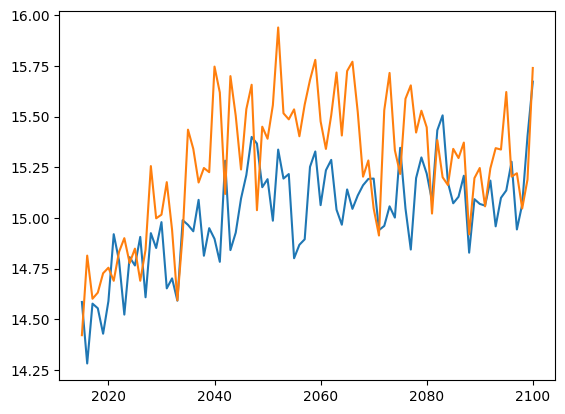

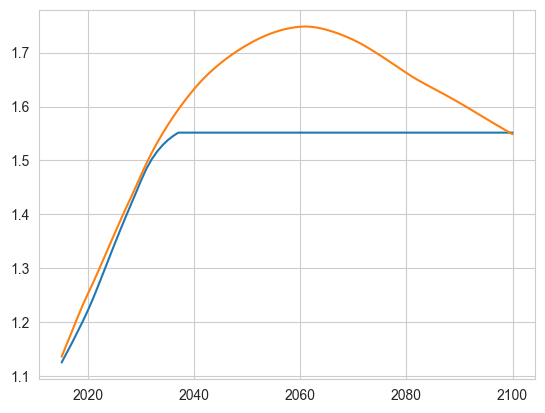

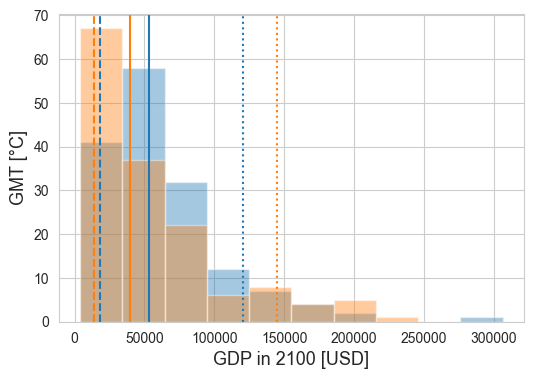

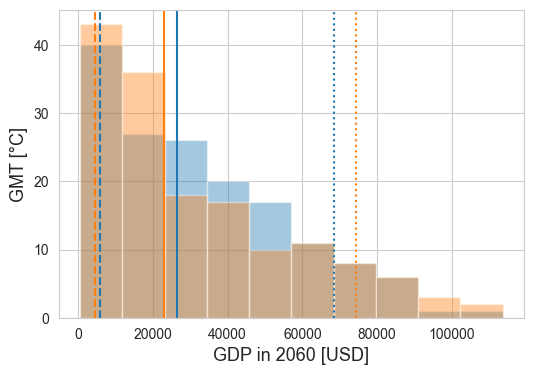

In [96]:
i,j = 76, 189

plt.figure()
plt.plot(np.linspace(2015, 2100, 86), gmt_tmp[i, :])
plt.plot(np.linspace(2015, 2100, 86), gmt_tmp[j, :])
plt.show()

with sns.axes_style("whitegrid"):
    plt.figure()
    plt.plot(np.linspace(2015, 2100, 86), gmt_tmp_smooth[i, :])
    plt.plot(np.linspace(2015, 2100, 86), gmt_tmp_smooth[j, :])
    plt.show()

run1        = i%100
scenario1   = int((i-run1)/100)

run2        = j%100
scenario2   = int((j-run2)/100)

gdp_scen_1 = gdp_df[(gdp_df.scen == scenarios_old[scenario1]) & (gdp_df.run == run1+1)].loc[:, ["year", "SSP2_clim"]]
gdp_scen_2 = gdp_df[(gdp_df.scen == scenarios_old[scenario2]) & (gdp_df.run == run2+1)].loc[:, ["year", "SSP2_clim"]]

with sns.axes_style('whitegrid'):
    plt.figure(figsize=(6,4))
    _, bins, _  = plt.hist(gdp_scen_1[gdp_scen_1.year == 2100].SSP2_clim, alpha = .4, color = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.2))
    plt.hist(gdp_scen_2[gdp_scen_2.year == 2100].SSP2_clim, alpha = .4, bins = bins, color = (1.0, 0.4980392156862745, 0.054901960784313725, 0.2))
    plt.axvline(np.median(gdp_scen_1[gdp_scen_1.year == 2100].SSP2_clim), color = "C0", linewidth = '1.5')
    plt.axvline(np.median(gdp_scen_2[gdp_scen_2.year == 2100].SSP2_clim), color = "C1", linewidth = '1.5')
    plt.axvline(np.quantile(gdp_scen_1[gdp_scen_1.year == 2100].SSP2_clim, q = 0.1), color = "C0", linewidth = '1.5', linestyle = "--")
    plt.axvline(np.quantile(gdp_scen_2[gdp_scen_2.year == 2100].SSP2_clim, q = 0.1), color = "C1", linewidth = '1.5', linestyle = "--")
    plt.axvline(np.quantile(gdp_scen_1[gdp_scen_1.year == 2100].SSP2_clim, q = 0.9), color = "C0", linewidth = '1.5', linestyle = "dotted")
    plt.axvline(np.quantile(gdp_scen_2[gdp_scen_2.year == 2100].SSP2_clim, q = 0.9), color = "C1", linewidth = '1.5', linestyle = "dotted")
    plt.xlabel('GDP in 2100 [USD]', fontsize = '13')
    plt.ylabel('GMT [°C]', fontsize = '13')
    plt.show()
    
    
year = 2060

with sns.axes_style('whitegrid'):
    plt.figure(figsize=(6,4))
    _, bins, _  = plt.hist(gdp_scen_1[gdp_scen_1.year == year].SSP2_clim, alpha = .4, color = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.2))
    plt.hist(gdp_scen_2[gdp_scen_2.year == year].SSP2_clim, alpha = .4, bins = bins, color = (1.0, 0.4980392156862745, 0.054901960784313725, 0.2))
    plt.axvline(np.median(gdp_scen_1[gdp_scen_1.year == year].SSP2_clim), color = "C0", linewidth = '1.5')
    plt.axvline(np.median(gdp_scen_2[gdp_scen_2.year == year].SSP2_clim), color = "C1", linewidth = '1.5')
    plt.axvline(np.quantile(gdp_scen_1[gdp_scen_1.year == year].SSP2_clim, q = 0.1), color = "C0", linewidth = '1.5', linestyle = "--")
    plt.axvline(np.quantile(gdp_scen_2[gdp_scen_2.year == year].SSP2_clim, q = 0.1), color = "C1", linewidth = '1.5', linestyle = "--")
    plt.axvline(np.quantile(gdp_scen_1[gdp_scen_1.year == year].SSP2_clim, q = 0.9), color = "C0", linewidth = '1.5', linestyle = "dotted")
    plt.axvline(np.quantile(gdp_scen_2[gdp_scen_2.year == year].SSP2_clim, q = 0.9), color = "C1", linewidth = '1.5', linestyle = "dotted")
    plt.xlabel(f'GDP in {year} [USD]', fontsize = '13')
    plt.ylabel('GMT [°C]', fontsize = '13')
    plt.show()

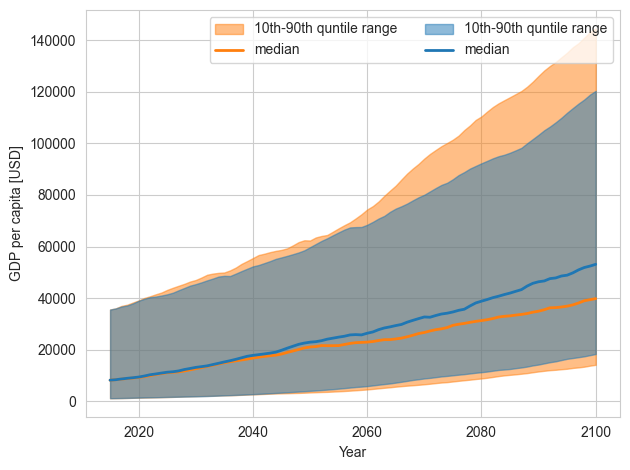

In [95]:
def q1(x):
    return x.quantile(0.1)

def q3(x):
    return x.quantile(0.9)

f = {'SSP2_clim': ['median', q1, q3]}


gdp_scen1_q_df = gdp_scen_1.groupby('year').agg(f)
gdp_scen2_q_df = gdp_scen_2.groupby('year').agg(f)

with sns.axes_style("whitegrid"):
    plt.figure()
    plt.fill_between(gdp_scen2_q_df.index, gdp_scen2_q_df.SSP2_clim.q1, gdp_scen2_q_df.SSP2_clim.q3, alpha = .5,
                     edgecolor = (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
                     facecolor = (1.0, 0.4980392156862745, 0.054901960784313725, 0.2),
                     label = "10th-90th quntile range")
    plt.plot(gdp_scen2_q_df.index, gdp_scen2_q_df.SSP2_clim["median"], color = "C1", linewidth = 2, label = "median")
    plt.fill_between(gdp_scen1_q_df.index, gdp_scen1_q_df.SSP2_clim.q1, gdp_scen1_q_df.SSP2_clim.q3, alpha = .5, 
                     edgecolor = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
                     facecolor = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.2), 
                     label = "10th-90th quntile range")
    plt.plot(gdp_scen1_q_df.index, gdp_scen1_q_df.SSP2_clim["median"], color = "C0", linewidth = 2,label = "median")
    plt.ylabel("GDP per capita [USD]")
    plt.xlabel("Year")
    plt.legend(ncols = 2)
    plt.tight_layout()
    plt.show()

6 148


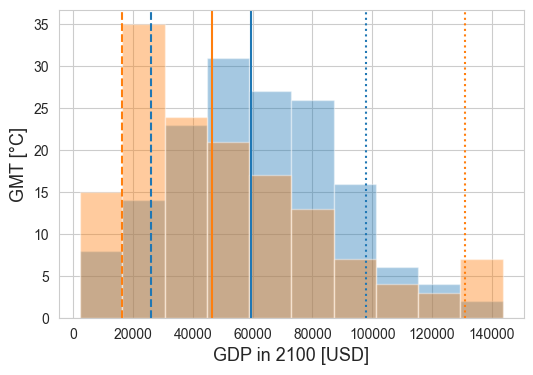

75 193


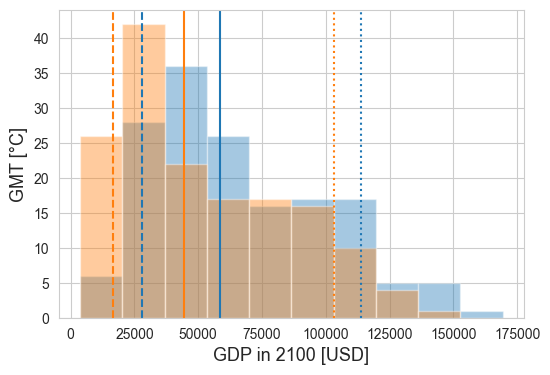

97 195


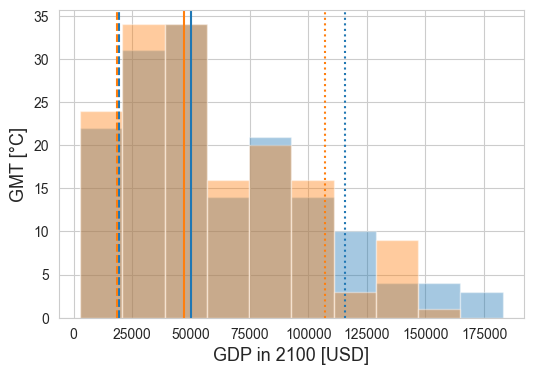

39 169


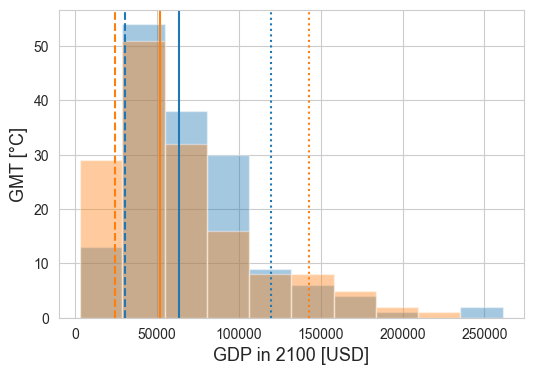

39 195


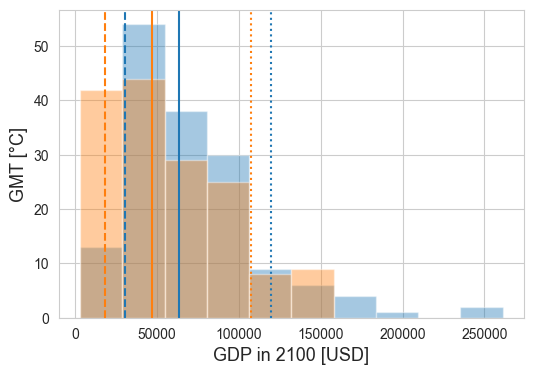

76 147


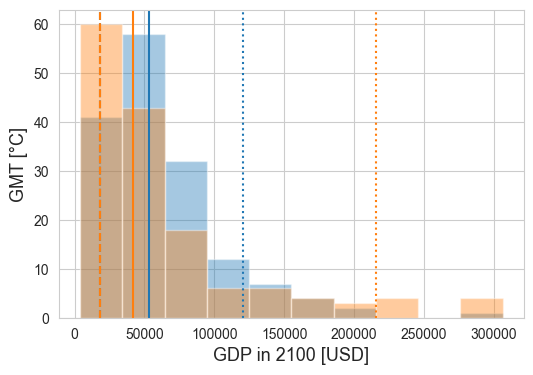

5 123


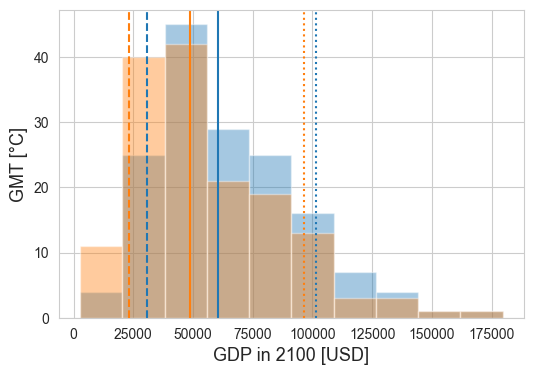

0 102


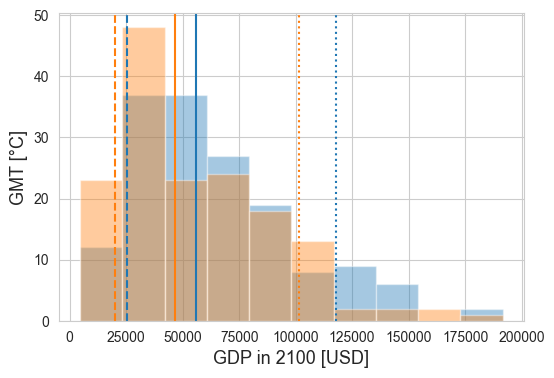

92 169


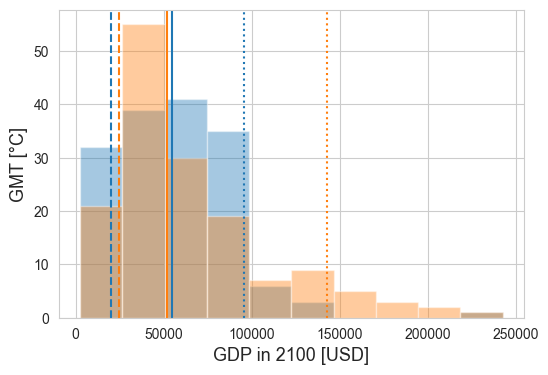

77 102


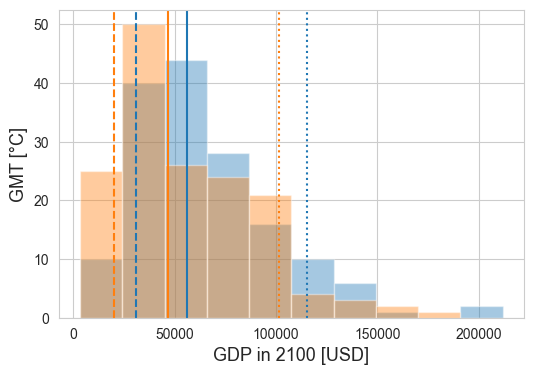

20 116


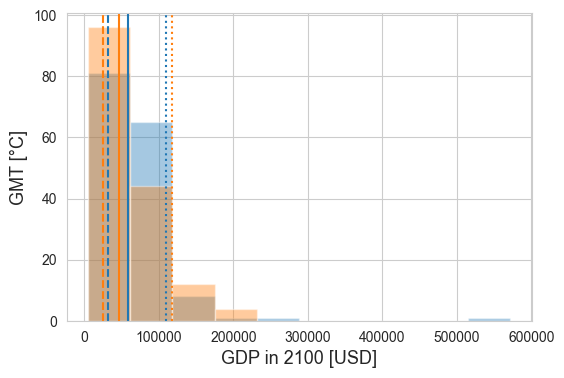

In [72]:
# i,j = 97, 195
# i,j = 39, 169
for i, j in [(6, 148), (75, 193), (97, 195), (39,169), (39, 195), (76, 147), (5,123), (0,102), (92, 169), (77, 102), (20,116)]: 
    print(i,j)
    run1        = i%100
    scenario1   = int((i-run1)/100)

    run2        = j%100
    scenario2   = int((j-run2)/100)

    gdp_scen_1 = gdp_df[(gdp_df.scen == scenarios_old[scenario1]) & (gdp_df.run == run1+1)].loc[:, ["year", "SSP2_clim"]]
    gdp_scen_2 = gdp_df[(gdp_df.scen == scenarios_old[scenario2]) & (gdp_df.run == run2+1)].loc[:, ["year", "SSP2_clim"]]
    
    with sns.axes_style('whitegrid'):
        plt.figure(figsize=(6,4))
        _, bins, _  = plt.hist(gdp_scen_1[gdp_scen_1.year == 2100].SSP2_clim, alpha = .4, color = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.2))
        plt.hist(gdp_scen_2[gdp_scen_2.year == 2100].SSP2_clim, alpha = .4, bins = bins, color = (1.0, 0.4980392156862745, 0.054901960784313725, 0.2))
        plt.axvline(np.median(gdp_scen_1[gdp_scen_1.year == 2100].SSP2_clim), color = "C0", linewidth = '1.5')
        plt.axvline(np.median(gdp_scen_2[gdp_scen_2.year == 2100].SSP2_clim), color = "C1", linewidth = '1.5')
        plt.axvline(np.quantile(gdp_scen_1[gdp_scen_1.year == 2100].SSP2_clim, q = 0.1), color = "C0", linewidth = '1.5', linestyle = "--")
        plt.axvline(np.quantile(gdp_scen_2[gdp_scen_2.year == 2100].SSP2_clim, q = 0.1), color = "C1", linewidth = '1.5', linestyle = "--")
        plt.axvline(np.quantile(gdp_scen_1[gdp_scen_1.year == 2100].SSP2_clim, q = 0.9), color = "C0", linewidth = '1.5', linestyle = "dotted")
        plt.axvline(np.quantile(gdp_scen_2[gdp_scen_2.year == 2100].SSP2_clim, q = 0.9), color = "C1", linewidth = '1.5', linestyle = "dotted")
        plt.xlabel('GDP in 2100 [USD]', fontsize = '13')
        plt.ylabel('GMT [°C]', fontsize = '13')
        plt.show()

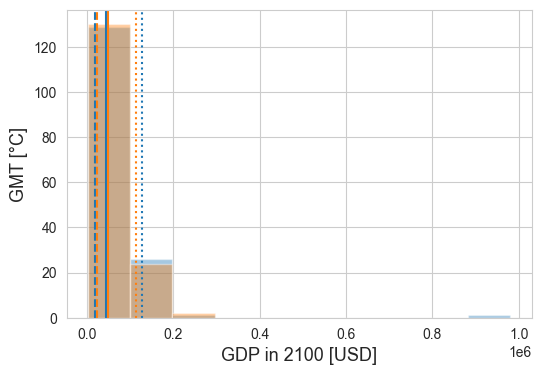

In [60]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(6,4))
    _, bins, _  = plt.hist(gdp_scen_1[gdp_scen_1.year == 2100].SSP2_clim, alpha = .4, color = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.2))
    plt.hist(gdp_scen_2[gdp_scen_2.year == 2100].SSP2_clim, alpha = .4, bins = bins, color = (1.0, 0.4980392156862745, 0.054901960784313725, 0.2))
    plt.axvline(np.median(gdp_scen_1[gdp_scen_1.year == 2100].SSP2_clim), color = "C0", linewidth = '1.5')
    plt.axvline(np.median(gdp_scen_2[gdp_scen_2.year == 2100].SSP2_clim), color = "C1", linewidth = '1.5')
    plt.axvline(np.quantile(gdp_scen_1[gdp_scen_1.year == 2100].SSP2_clim, q = 0.1), color = "C0", linewidth = '1.5', linestyle = "--")
    plt.axvline(np.quantile(gdp_scen_2[gdp_scen_2.year == 2100].SSP2_clim, q = 0.1), color = "C1", linewidth = '1.5', linestyle = "--")
    plt.axvline(np.quantile(gdp_scen_1[gdp_scen_1.year == 2100].SSP2_clim, q = 0.9), color = "C0", linewidth = '1.5', linestyle = "dotted")
    plt.axvline(np.quantile(gdp_scen_2[gdp_scen_2.year == 2100].SSP2_clim, q = 0.9), color = "C1", linewidth = '1.5', linestyle = "dotted")
    plt.xlabel('GDP in 2100 [USD]', fontsize = '13')
    plt.ylabel('GMT [°C]', fontsize = '13')
    plt.show()

In [66]:
gdp_scen_1 = gdp_df.loc[(gdp_df.scen == 'Ref1p5'), ['iso', 'year', 'SSP2_clim']].groupby(['iso', 'year']).mean().reset_index()
gdp_scen_2 = gdp_df.loc[(gdp_df.scen == 'Neg'), ['iso', 'year', 'SSP2_clim']].groupby(['iso', 'year']).mean().reset_index()

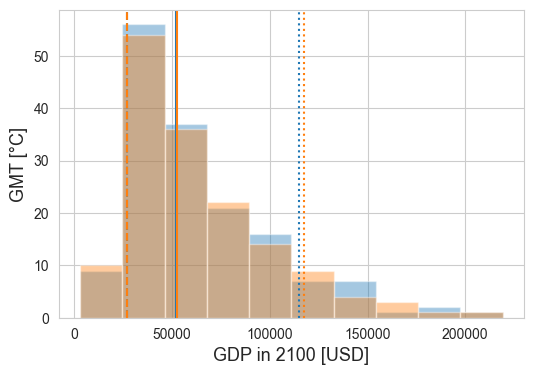

In [67]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(6,4))
    _, bins, _  = plt.hist(gdp_scen_1[gdp_scen_1.year == 2100].SSP2_clim, alpha = .4, color = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.2))
    plt.hist(gdp_scen_2[gdp_scen_2.year == 2100].SSP2_clim, alpha = .4, bins = bins, color = (1.0, 0.4980392156862745, 0.054901960784313725, 0.2))
    plt.axvline(np.median(gdp_scen_1[gdp_scen_1.year == 2100].SSP2_clim), color = "C0", linewidth = '1.5')
    plt.axvline(np.median(gdp_scen_2[gdp_scen_2.year == 2100].SSP2_clim), color = "C1", linewidth = '1.5')
    plt.axvline(np.quantile(gdp_scen_1[gdp_scen_1.year == 2100].SSP2_clim, q = 0.1), color = "C0", linewidth = '1.5', linestyle = "--")
    plt.axvline(np.quantile(gdp_scen_2[gdp_scen_2.year == 2100].SSP2_clim, q = 0.1), color = "C1", linewidth = '1.5', linestyle = "--")
    plt.axvline(np.quantile(gdp_scen_1[gdp_scen_1.year == 2100].SSP2_clim, q = 0.9), color = "C0", linewidth = '1.5', linestyle = "dotted")
    plt.axvline(np.quantile(gdp_scen_2[gdp_scen_2.year == 2100].SSP2_clim, q = 0.9), color = "C1", linewidth = '1.5', linestyle = "dotted")
    plt.xlabel('GDP in 2100 [USD]', fontsize = '13')
    plt.ylabel('GMT [°C]', fontsize = '13')
    plt.show()

6 148


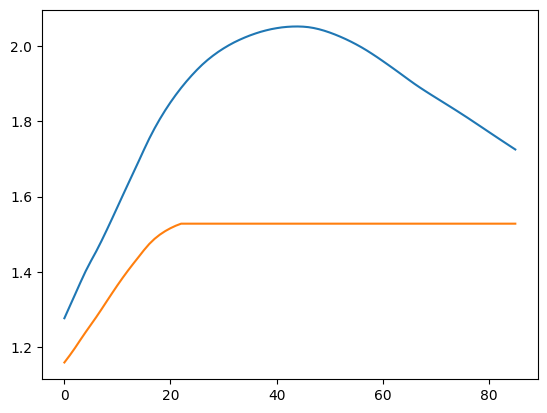

75 193


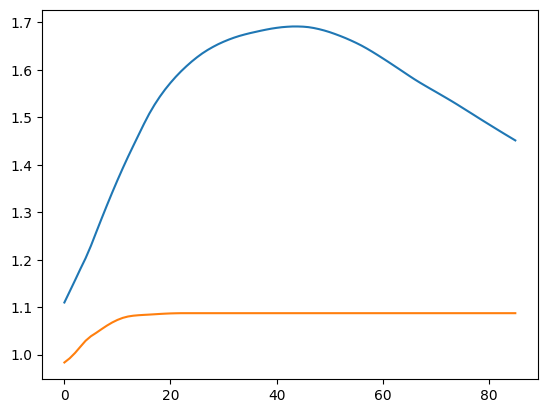

97 195


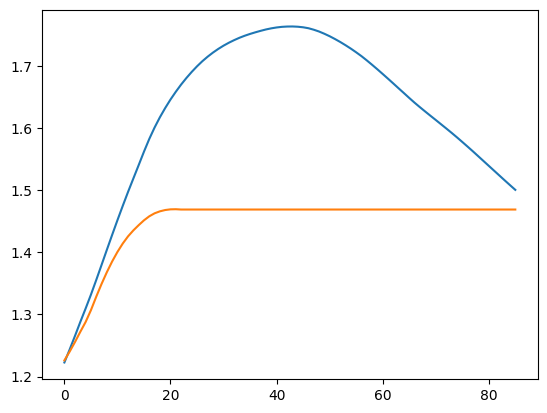

39 169


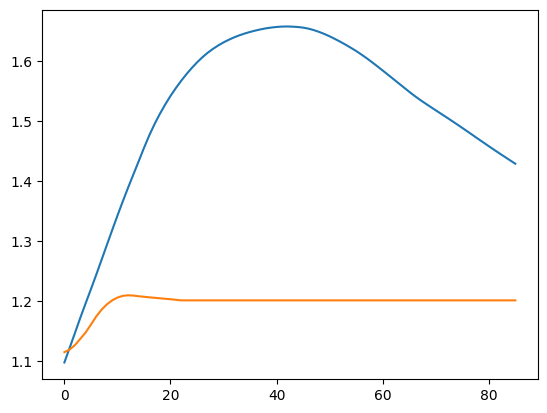

39 195


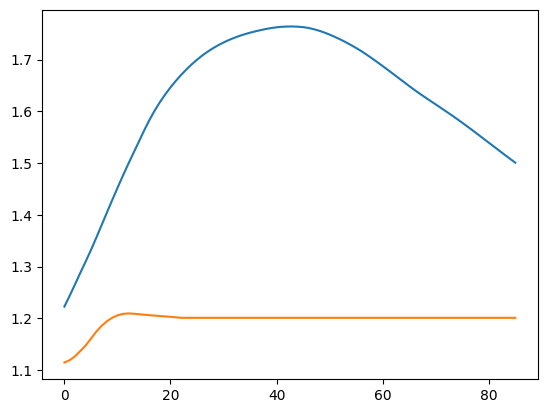

76 147


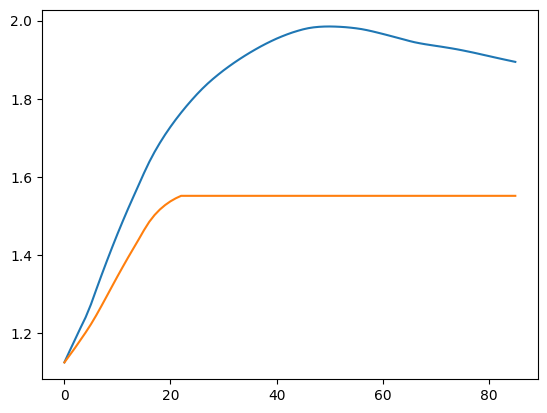

5 123


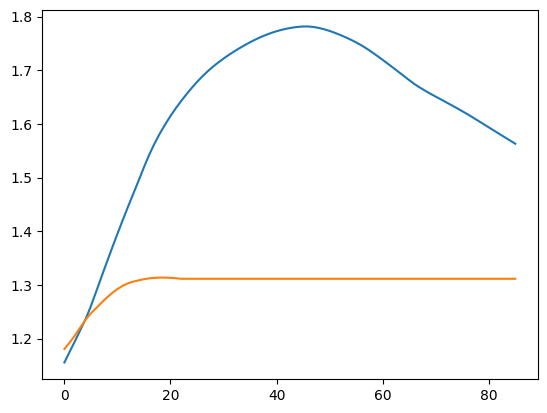

0 102


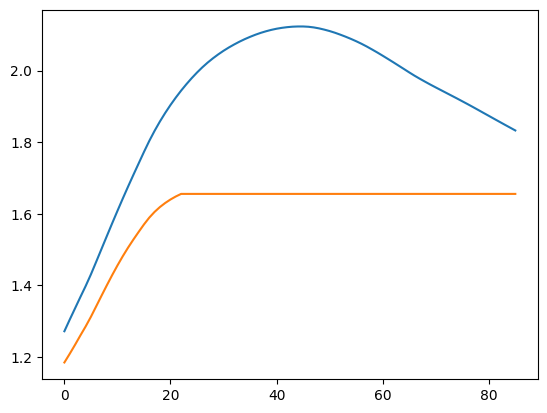

92 169


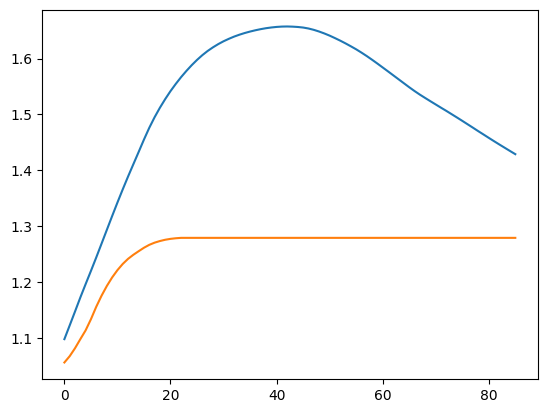

77 102


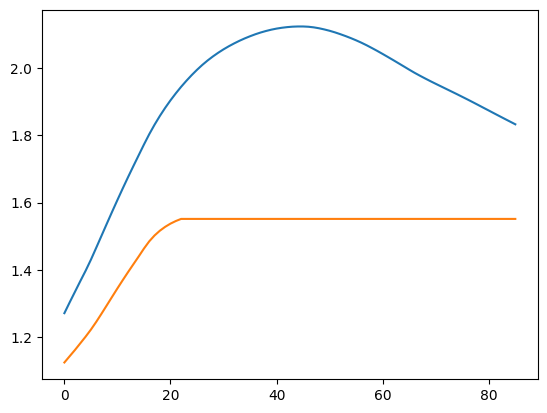

20 116


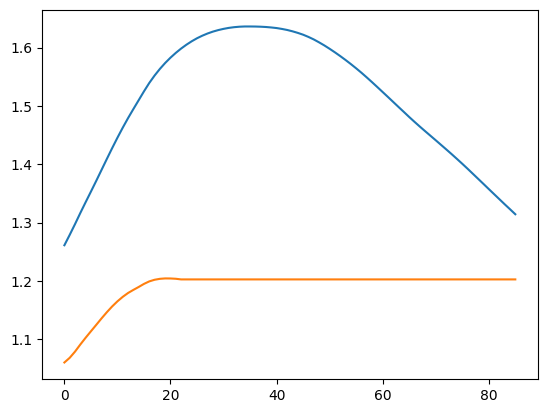

In [73]:
# options: [(6, 148), (75, 193), (97, 195), (39,169), (39, 195), (76, 147), (5,123), (0,102), (92, 169), (77, 102), (20,116)] 
for i, j in [(6, 148), (75, 193), (97, 195), (39,169), (39, 195), (76, 147), (5,123), (0,102), (92, 169), (77, 102), (20,116)]: 
    print(i,j)
    plt.figure()
    plt.plot(gmt_tmp_smooth[j, :])
    plt.plot(gmt_tmp_smooth[i, :])
    plt.show()

In [33]:
# for i,j in sel_tuples[200:]: 
#     print(i,j)
#     plt.figure()
#     plt.plot(gmt_tmp[j, :]-14.72)
#     plt.plot(gmt_tmp[i, :]-14.72)
#     plt.show()

In [ ]:

with sns.axes_style("whitegrid"):
    i,j = 415, 678
    print(i,j)
    plt.figure()
    plt.plot(gmt_tmp[j, :]-14.72)
    plt.plot(gmt_tmp[i, :]-14.72)
    plt.show()

    plt.figure()
    plt.plot(gmt_tmp[j, :]-14.42)
    plt.plot(gmt_tmp[i, :]-14.42)
    plt.show()